**Ensemble Learning and Random Forests**

> Indented block



# Setup

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Voting classifiers

In [ ]:
# assign heads probability
heads_proba = 0.51
# create a matrix of coin tosses as decimal values
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
# rearrange matrix and calculate a cumulative average of heads vs tails to plot as each toss progresses
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


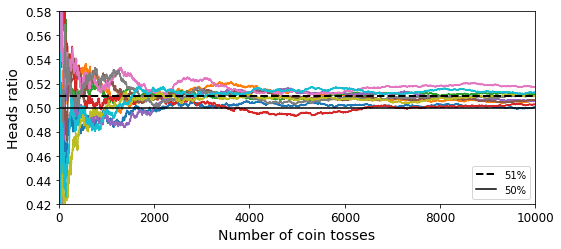

In [ ]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

Here, we see the law of large numbers in effect. Over many coin tosses, the true probability emerges for all of the trials.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

# generate some data for classification
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

**Note**: to be future-proof, we set `solver="lbfgs"`, `n_estimators=100`, and `gamma="scale"` since these will be the default values in upcoming Scikit-Learn versions.

### "Hard" voting

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# initialize three different classifiers
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)

# initialize a democratic voting classifier with 'hard' classification
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [ ]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [ ]:
from sklearn.metrics import accuracy_score

# train each classifier and show the results
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


Here we can see the Voting Classifier does the best. Why is this?

### "Soft" voting

In [ ]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


Again, we see the Voting Classifier is performing better than the other classifiers. How does it compare to hard voting? Is this always the case?

# Bagging Ensembles

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Manually creating a random forest
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)

# Train and predict with our manual random forest
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.904


In [ ]:
# Train and predict with a single decision tree
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


Why did the random forest do better? Let's visualize their decision boundaries.

In [ ]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

Saving figure decision_tree_without_and_with_bagging_plot


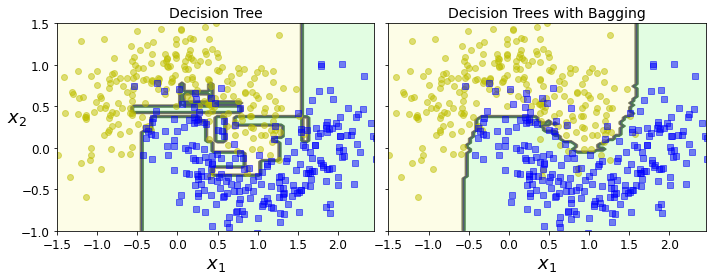

In [ ]:
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.ylabel("")
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

Here we can see the random forest decision boundary is much smoother and nuanced. This is because many individual rougher decision tree boundaries combined turn into a smooth separation plane.

# Random Forests

As we saw earlier, random forests are the top of mind example of bagging classifiers. Here we will explore them further.

In [ ]:
# Create a manual random forest
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, random_state=42)

# Train and predict
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a pre-built random forest
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)

# Train and predict
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
# Compare them - should be very similar if not the exact same
np.sum(y_pred == y_pred_rf) / len(y_pred)

1.0

Why are these so similar? Should be easy to say by now.

Now, let's take a look at an example of feature importance with a trained random forest. What is feature importance?

Feature importance is the measure of how "helpful" each feature provided is in the model. This is determined by the information gain at each split using that feature. Let's see an example:

In [ ]:
from sklearn.datasets import load_iris

# Load data
iris = load_iris()

# Instantiate and train model
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])

# View each feature importance
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876375
sepal width (cm) 0.02311928828251033
petal length (cm) 0.4410304643639577
petal width (cm) 0.4233579963547682


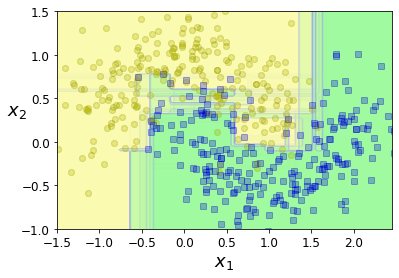

In [ ]:
plt.figure(figsize=(6, 4))

# Train and plot 15 decision trees to visualize boundary variation
for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)

    # Boostrap aggregation (bagging)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])

    # Plot boundary
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.02, contour=False)

plt.show()

## Out-of-Bag evaluation

What is Out-of-Bag data?

When a bootstrapped dataset is created (once per weak-learner [decision tree in case of random forest]), OOB data is the collection of rows NOT chosen to train the learner.

For example:

Dataset has rows A, B, C, D

Tree 1

Bootstrapped set: A, A, B, D

Out-of-Bag set: C

Tree 2

Bootstrapped set: B, C, B, C

Out-of-Bag set: A, D

Tree 3

Bootstrapped set: D, B, C, A

Out-of-Bag set: _

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.8986666666666666

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

What can we conclude from this? When is OOB scoring useful?

We can't necessarily "conclude" anything. OOB scoring, like cross validation, is a way to measure error in a more clever and comprehensive way than a simple accuracy score. OOB scoring is not always necessary, but it's important to understand what it is, especially beause it reinforces our understanding of how bagging works.

## Feature importance

**Warning:** since Scikit-Learn 0.24, `fetch_openml()` returns a Pandas `DataFrame` by default. To avoid this and keep the same code as in the book, we use `as_frame=False`.

In [ ]:
from sklearn.datasets import fetch_openml

# Load the data
mnist = fetch_openml('mnist_784', version=1, as_frame=False)

# Set target as numerical type
mnist.target = mnist.target.astype(np.uint8)

# Instantiate and train random forest
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

# Define function to plot the digits
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


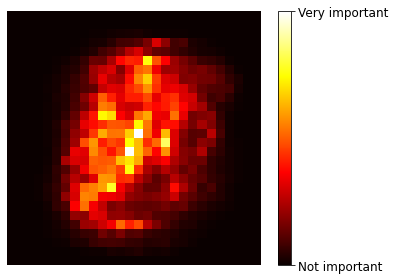

In [ ]:
# Visualize which areas the model determined to be most important as model features
plot_digit(rnd_clf.feature_importances_)
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# AdaBoost

What is adaboost? Adaptive Boosting is a boosting algorithm designed for random forests. It consists of 3 parts:
- Weak learners (trees)
- Learning from previous mistakes when building new learners
- Varied learner importance

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Instantiate and train an adaboost model with decision trees as weak learners
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

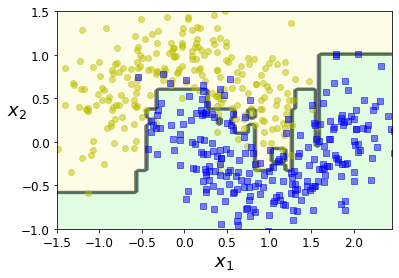

In [ ]:
# Show the decision boundary
plot_decision_boundary(ada_clf, X, y)

Saving figure boosting_plot


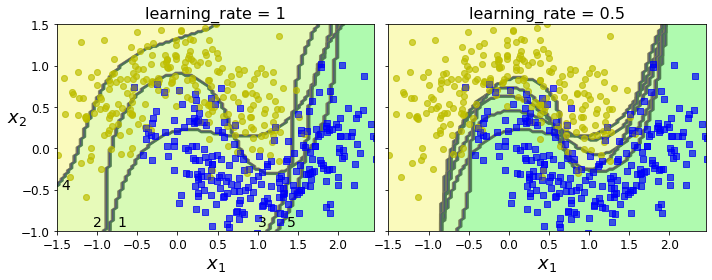

In [ ]:
# Plot the decision boundaries with two different learning rates
m = len(X_train)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step

        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=14)
        plt.text(-1.05, -0.95, "2", fontsize=14)
        plt.text(1.0, -0.95, "3", fontsize=14)
        plt.text(-1.45, -0.5, "4", fontsize=14)
        plt.text(1.36,  -0.95, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

High learning rate pros:
- Less likely to get stuck in local minima
- Converge in less iterations

High learning rate cons:
- Diverge instead of converge
- Unstable, not show clear signs of progress

Low learning rate pros:
- Less likely to diverge

Low learning rate cons:
- May take too many iterations (slow, computationally expensive)
- Get stuck in local minima



# Gradient Boosting

### How is Gradient Boosting different from Bagging?
- Boosting is done by training subsequent estimators on the error of the previous ones
- Datapoints that have been estimated incorrectly are weighted more heavily more often
- Because of this nature of correcting previous errors, parallel training ability is limited
- Therefore, slightly longer training times
- Estimators in a Bagging ensemble are independent, and can therefore be trained fully in parallel

### Boosting seems "smarter", right? Does this mean you always want to use Boosting over Bagging?
- No, Boosting can overfit more easily if you're not careful. This is what it's designed to do.
- However, Boosting is usually superior to Bagging under most circumstances as a rule of thumb

In [ ]:
# Create a y based on X with a slight margin for error to throw the classifier off at first
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
y

array([ 0.62779246,  0.03017018,  0.59084982,  0.18097017,  0.02748653,
        0.05774521,  0.15074422,  0.11381777,  0.08777425,  0.42421509,
        0.23412877,  0.43374105,  0.52587452,  0.27926387,  0.01865748,
        0.00632805, -0.02341793,  0.71047828,  0.01411922,  0.19315327,
       -0.03320764,  0.27213552, -0.06075699,  0.18564774,  0.03674484,
        0.02832896,  0.12914282,  0.04132554,  0.50627492,  0.61364998,
        0.14884226,  0.18018944,  0.1701554 , -0.01189625,  0.59120936,
        0.33659285, -0.06534142,  0.57901039,  0.47343613,  0.84723176,
        0.16447327,  0.52569146,  0.05391555,  0.16775215,  0.12970609,
        0.3826675 ,  0.16408547,  0.20142374,  0.05972054,  0.0127181 ,
        0.03746704,  0.20300784,  0.59323834,  0.30899418,  0.26341466,
        0.17774702,  0.63057477,  0.04679962,  0.44270679,  0.66507358,
        0.69044309,  0.04683162,  0.36149073,  0.2682741 ,  0.52198394,
        0.36630811,  0.20692187,  0.49236403,  0.21787809,  0.72

In [ ]:
from sklearn.tree import DecisionTreeRegressor

# Fit a tree on the data
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
# Derive residual errors from first tree as y2
y2 = y - tree_reg1.predict(X)
# Fit a new tree on the residuals
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
# Rinse and repeat for risidual errors from second tree
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
# Define a new plot function to visualize our residual predictions
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


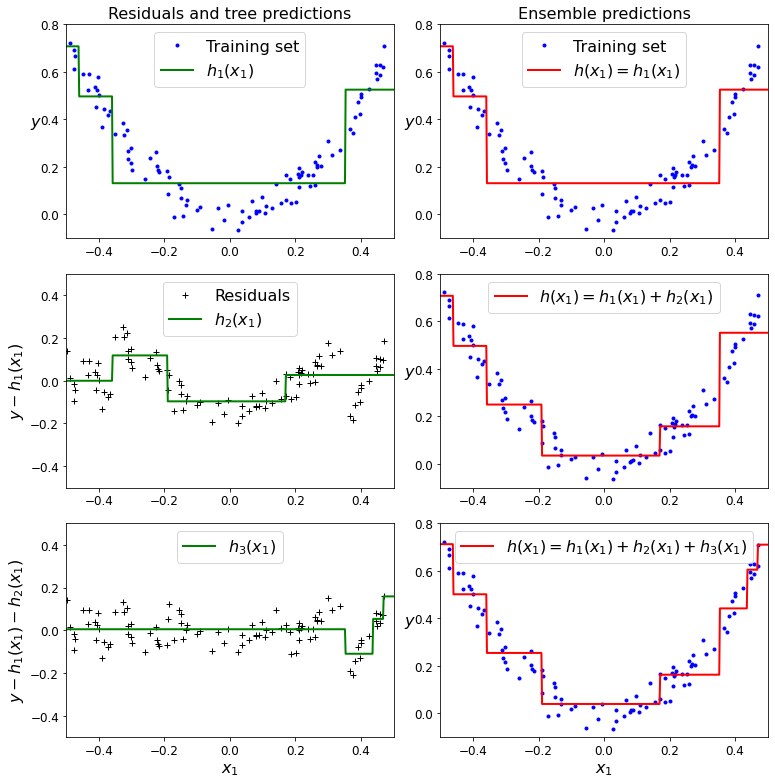

In [ ]:
# Plot them
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Instantiate a standard gradient boosting regressor with 3 estimators to compare
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [ ]:
# Define the same model but with 200 estimators
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

Saving figure gbrt_learning_rate_plot


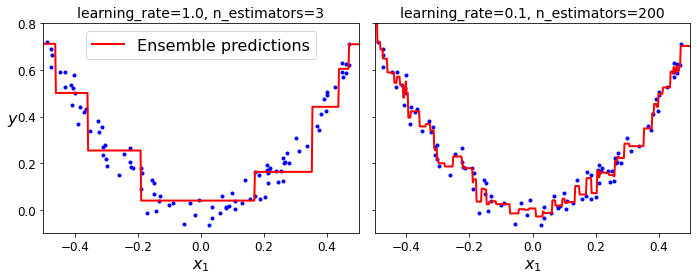

In [ ]:
# Plot results
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

Here we see the predictions become a lot smoother. In fact, it may even be overfitting in some areas. This is likely because 200 estimators was too many, and our model would be less error prone (due to variance). Overall, the curve is a much better fit than the 3 estimator model, but could be even better with less trees.

## Gradient Boosting with Early stopping

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

# Train classifier
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

# Get a vector of errors corresponding to a prediction for each stage
errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
# Find best number of estimators through min error
bst_n_estimators = np.argmin(errors) + 1

# Train a new classifier with the optimal number of estimators
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=73, random_state=42)

In [ ]:
# Best error
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


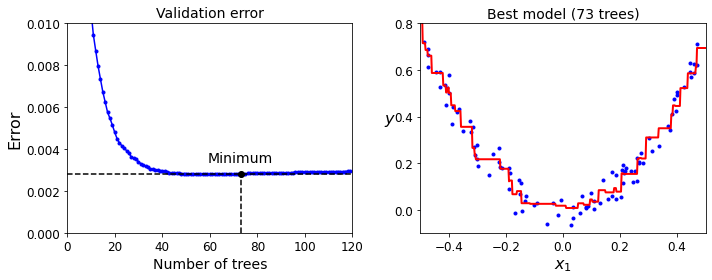

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

Here was can see that the error levels out, and even gets slightly worse above ~100 trees. This is a form of hyperparameter tuning.

In [ ]:
# An efficient way to train a model without letting it get too complex: early stopping
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)

    # We are still optimizing properly
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0

    # Our model is starting to get worse. After 5 times of this, cut it off.
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

print(gbrt.n_estimators)
print("Minimum validation MSE:", min_val_error)

64
Minimum validation MSE: 0.0028092395481558487


## Using XGBoost

In [ ]:
# Not from sklearn, must install separately
try:
    import xgboost
except ImportError as ex:
    print("Error: the xgboost library is not installed.")
    xgboost = None

In [ ]:
# Show final error after training xgboost fully
if xgboost is not None:  # not shown in the book
    xgb_reg = xgboost.XGBRegressor(random_state=42)
    xgb_reg.fit(X_train, y_train)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred) # Not shown
    print("Validation MSE:", val_error)           # Not shown

[02:14:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Validation MSE: 0.0029005221259797


In [ ]:
# Show final error with early stopping - is it better?
if xgboost is not None:  # not shown in the book
    xgb_reg.fit(X_train, y_train,
                eval_set=[(X_val, y_val)], early_stopping_rounds=2)
    y_pred = xgb_reg.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)  # Not shown
    print("Validation MSE:", val_error)            # Not shown

[02:14:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.27513
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.251486
[2]	validation_0-rmse:0.229911
[3]	validation_0-rmse:0.210877
[4]	validation_0-rmse:0.193273
[5]	validation_0-rmse:0.176471
[6]	validation_0-rmse:0.161246
[7]	validation_0-rmse:0.149142
[8]	validation_0-rmse:0.137152
[9]	validation_0-rmse:0.127369
[10]	validation_0-rmse:0.118129
[11]	validation_0-rmse:0.109814
[12]	validation_0-rmse:0.10299
[13]	validation_0-rmse:0.097188
[14]	validation_0-rmse:0.091548
[15]	validation_0-rmse:0.086003
[16]	validation_0-rmse:0.081374
[17]	validation_0-rmse:0.077122
[18]	validation_0-rmse:0.073323
[19]	validation_0-rmse:0.070572
[20]	validation_0-rmse:0.068526
[21]	validation_0-rmse:0.066422
[22]	validation_0-rmse:0.064148
[23]	validation_0-rmse:0.062522
[24]	validation_0-rmse:0.061069
[25]	validation_0-rms

In [ ]:
%timeit GradientBoostingRegressor().fit(X_train, y_train) # Showing how fast XGBoost is - it's optimized for training performance.

10 loops, best of 5: 42.5 ms per loop
